In [2]:
# Libraries used.

# Frequent itemsets + association rules
library(arules);

# Python-like fstrings.
library(glue);

library(dplyr);

# Plots.
library(ggplot2);

# B-splines for 'ggplot' smooth plots. 
library(splines);

# Reading .csv in efficient way.
library(data.table);


In [3]:
# Helper functions.

m  = function(x) print(methods(class=class(x)))
p  = function(x) print(glue(x))
ph = function(x) print(head(x))
pt = function(x) print(tail(x))
pc = function(x) print(class(x))


In [4]:
# WARNING - disk size of data file is about 5.4GB, and after reading it into RAM
# R process uses about 6.4GB of memory.

# DATA_FNAME = "MAX_TRIMMED.csv" # "MINI_TRIMMED.csv" # "clash_royale_games_Jan_2019.csv"
# data = data[sample(nrow(data), MINI_DATA_LEN), ]
# MINI_DATA_LEN = 100000;
# write.csv(data, file=DATA_FNAME)


DATA_FNAME = "res.csv"
data = fread(DATA_FNAME)


Warning message in fread(DATA_FNAME):
“Detected 3 column names but the data has 9 columns (i.e. invalid file). Added 6 extra default column names at the end.”


In [5]:
# Sort games by timestamp.
data = data[order(data$timestamp, decreasing=FALSE)]
data_len = length(data$timestamp)
data_begin_day = format(data$timestamp[[1]], '%d-%m-%Y')
data_end_day = format(data$timestamp[[data_len]], '%d-%m-%Y')

p("Our dataset contains results of {data_len} games played from {data_begin_day} up to {data_end_day}.")


Our dataset contains results of 100000 games played from 31-12-2018 up to 31-01-2019.


In [6]:
# Read transactions.

# TODO - reading subset of 100k transactions takes 45sec, thus reading whole data (50M = 500 * 100k transactions) will take like 6 hours.
transactions = arules::read.transactions(DATA_FNAME, format="basket", head=1, sep=',', cols=1)

In [7]:
# For each game we introduce two transactions - one for each players (single transaction contains set of cards from one player's deck).
inspect(head(transactions, n=1))
inspect(tail(transactions, n=1))

    items               transactionID
[1] {bandit,                         
     barbarians,                     
     miner,                          
     prince,                         
     princess,                       
     the-log,                        
     valkyrie,                       
     wizard}     2019-01-04T15:15:10Z
    items                   transactionID
[1] {arrows,                             
     balloon,                            
     bats,                               
     electro-wizard,                     
     freeze,                             
     inferno-dragon,                     
     mega-knight,                        
     witch}          2019-01-08T20:36:52Z


In [8]:
minSupport = 0.01

# Generate frequent itemsets (using arules::Apriori implementation). 
frequentItemSets = apriori(transactions, 
                           parameter = list(supp = minSupport, 
                                            minlen = 1, 
                                            target = "frequent itemsets"),
                           appearance = NULL, control = list(verbose = FALSE))

# frequentItemSets = eclat(transactions, parameter = list(supp = minSupport, 
#                                                         minlen = 2, 
#                                                         target = "frequent itemsets",
#                                                         tidLists = FALSE),
#                               control = list(verbose = FALSE))

In [9]:
# n_sets(x) returns list of frequent itemsets of size 'x', sorted decreasing by support value.
n_sets = function(frequent_itemsets, n) arules::sort(frequent_itemsets[which(size(frequent_itemsets) == n)], decreasing=TRUE)


In [10]:
# Look for single most-popular cards (Overall time).
a = n_sets(frequentItemSets, 1)
inspect(head(a))
l = labels(a[1])
s = support(a[1], transactions)
p("Here is the list of most popular cards (overall). The most popular card, the {l} was used in {100 * s}% of all decks!")


    items         support transIdenticalToItemsets count
[1] {zap}         0.43466 0                        43466
[2] {fireball}    0.33260 0                        33260
[3] {wizard}      0.28597 0                        28597
[4] {the-log}     0.28137 0                        28137
[5] {hog-rider}   0.27026 0                        27026
[6] {goblin-gang} 0.25893 0                        25893
Here is the list of most popular cards (overall). The most popular card, the {zap} was used in 43.466% of all decks!


In [11]:
df = as.Date(transactionInfo(transactions)$transactionID, format="%Y-%m-%dT%H:%M:%S")
split_groups = df - min(df)
s = split(transactions, split_groups)
head(split_groups)

Time differences in days
[1]  4  5 31  7 29  5

In [12]:
# What about card popularity in time? Let's investigate splitted by consecutive few-day chunks data.

# https://stackoverflow.com/a/16275428
# chunk2 <- function(x,n) split(x, cut(seq_along(x), n, labels = FALSE)) 
# bins = 10

df = as.Date(transactionInfo(transactions)$transactionID, format="%Y-%m-%dT%H:%M:%S")
split_groups = df - min(df)
s = split(transactions, split_groups)

# TODO we can improve it easily (using split_groups).
x_axis = lapply(s, function(x) transactionInfo(x)[[1]][[1]])
x_axis = lapply(x_axis, as.Date, format="%Y-%m-%dT%H:%M:%S")

res = data.frame()
popular_cards = c()
for (v in 1:length(s)) {
    f = apriori(s[[v]], 
                parameter = list(supp = minSupport, 
                                minlen = 1, 
                                maxlen = 1,
                                target = "frequent itemsets"),
                appearance = NULL, control = list(verbose = FALSE))
    f = DATAFRAME(n_sets(f, 1))
    f$chunk = v
    f$chunk_start_date = x_axis[[v]]
    # print(head(f))
    popular_cards = c(popular_cards, as.character(f$items[1:4]))
    res = rbind(res, f)
}
popular_cards = as(popular_cards, "matrix")
popular_in_time = dplyr::filter(res, items %in% popular_cards)


Popularity of 9 most frequently used cards in time.
[1] "As we see, the Zap card's usage trend is growing, while Princess card's trend is decreasing in time."


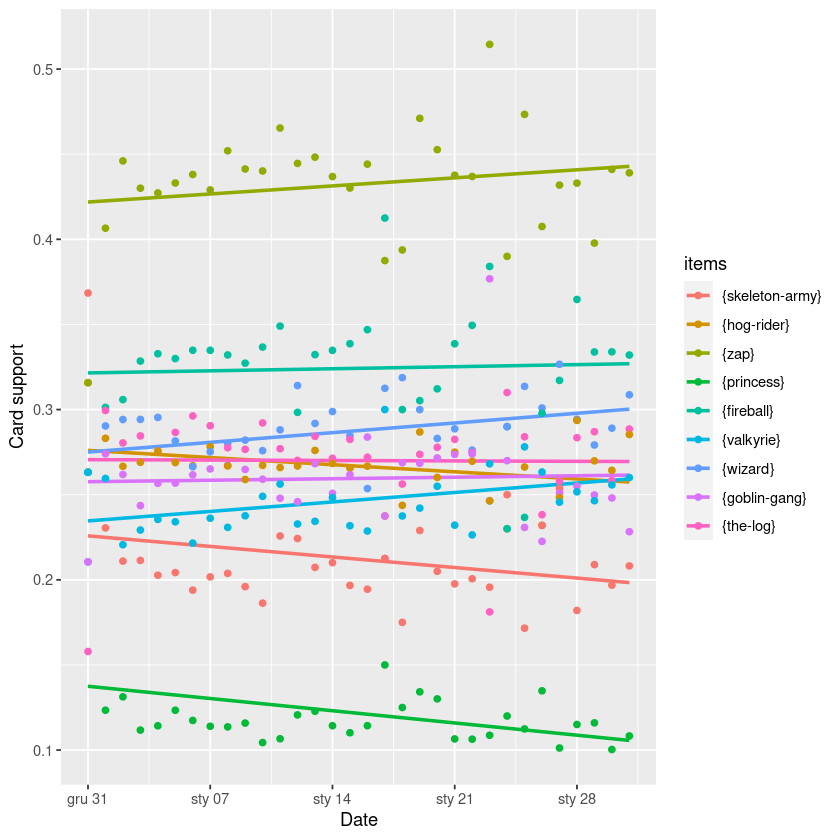

In [14]:
p("Popularity of {length(unique(popular_cards))} most frequently used cards in time.")
gg = ggplot(popular_in_time, aes(x=chunk_start_date, y=support, colour=items))
gg = gg + stat_smooth(
    aes(x = chunk_start_date, y = support, colour=items), 
    method = "lm", 
    se=FALSE, 
    fullrange=TRUE, 
    formula = y ~ x, # ns(x, 30)
) 
gg = gg + geom_point()
gg = gg + xlab("Date") + ylab("Card support")
# gg = gg + theme(legend.position = "none")
plot(gg)
print("As we see, the Zap card's usage trend is growing, while Princess card's trend is decreasing in time.")

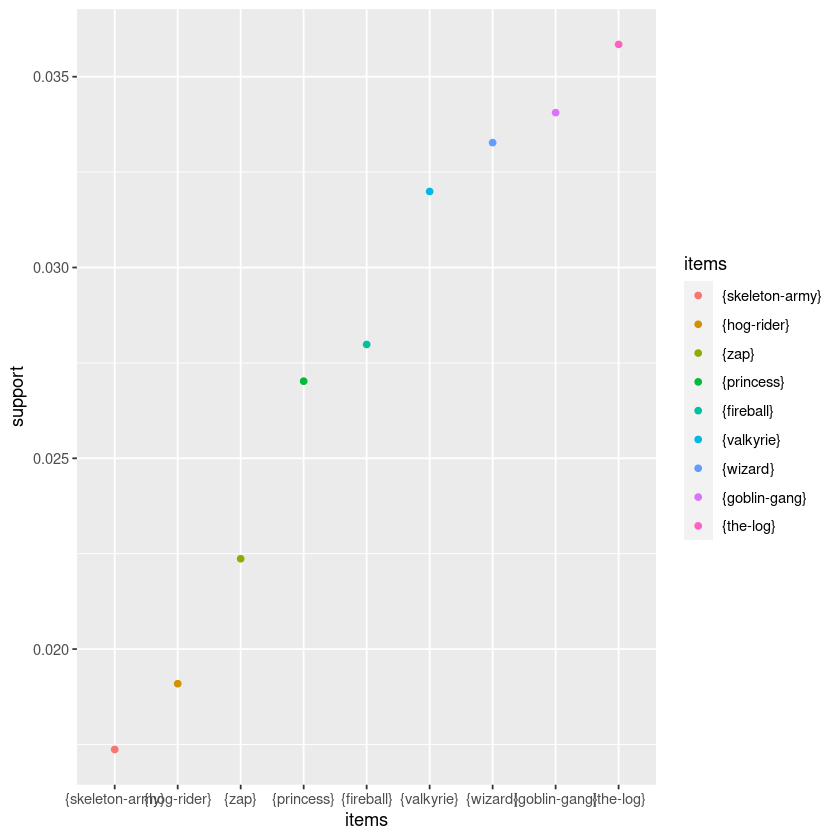

In [59]:
# We can see at variances of support of particular cards.
deviations = aggregate(. ~ items, popular_in_time, FUN=sd)
deviations$support = deviations$support[order(deviations$support)]
gg = ggplot(deviations, aes(x=items, y=support, colour=items))
gg = gg + geom_point()
plot(gg)


In [79]:
# Now, let's investigate support of combos of size 2 and 3.

p("We see an interesting thing. 4-combos are much different than 2 or 3 combos (maybe Goblin cards together give player bonuses?)\n\n\n")

two_combos = n_sets(frequentItemSets, 2)
inspect(head(two_combos))
# two_combos= DATAFRAME(two_combos)
# gg = ggplot(head(two_combos), aes(x=items, y=support, colour=items))
# gg = gg + geom_point()
# plot(gg)

three_combos = n_sets(frequentItemSets, 3)
inspect(head(three_combos))

four_combos = n_sets(frequentItemSets, 4)
inspect(head(four_combos))


We see an interesting thing. 4-combos are much different than 2 or 3 combos (maybe Goblin cards together give player bonuses?)


    items                support transIdenticalToItemsets count
[1] {fireball,zap}       0.14838 0                        14838
[2] {hog-rider,zap}      0.12760 0                        12760
[3] {goblin-gang,zap}    0.11928 0                        11928
[4] {fireball,hog-rider} 0.11503 0                        11503
[5] {wizard,zap}         0.10539 0                        10539
[6] {fireball,the-log}   0.10295 0                        10295
    items                        support transIdenticalToItemsets count
[1] {fireball,hog-rider,zap}     0.05262 0                        5262 
[2] {fireball,hog-rider,the-log} 0.04291 0                        4291 
[3] {bats,goblin-gang,zap}       0.03958 0                        3958 
[4] {fireball,minions,zap}       0.03805 0                        3805 
[5] {fireball,goblin-gang,zap}   0.03659 0                     

In [108]:
rules = ruleInduction(frequentItemSets, transactions, confidence = 0.6, 
                           control = list(method = "apriori", verbose = FALSE))

# inspect(head(rules))

lhs_rules = function(lhs) {
    res = dplyr::filter(DATAFRAME(rules), grepl(lhs, as.character(LHS)))
    res = res[order(res$support, decreasing=TRUE),]
    res
}
cannon_rules = lhs_rules("cannon")
head(cannon_rules)


,LHS,RHS,support,confidence,coverage,lift,count
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,{cannon},{hog-rider},0.01874,0.6992537,0.02680,2.587337,1874
2,{cannon},{fireball},0.01851,0.6906716,0.02680,2.076583,1851
39,"{cannon,hog-rider}",{fireball},0.01538,0.8207044,0.01874,2.467542,1538
40,"{cannon,fireball}",{hog-rider},0.01538,0.8309022,0.01851,3.074455,1538
31,"{cannon,musketeer}",{hog-rider},0.01379,0.8885309,0.01552,3.287689,1379
32,"{cannon,hog-rider}",{musketeer},0.01379,0.7358591,0.01874,7.041714,1379


We managed to find most popular cards and set of cards, and to investigate it's popularity in time.
We have mined some association rules, which is first step to create our recommendation system.
However, for now **we haven't took games results (win or lose) into consideration**. Now it's time to take deck winning ratio into account.